In [12]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from matplotlib.patches import Wedge

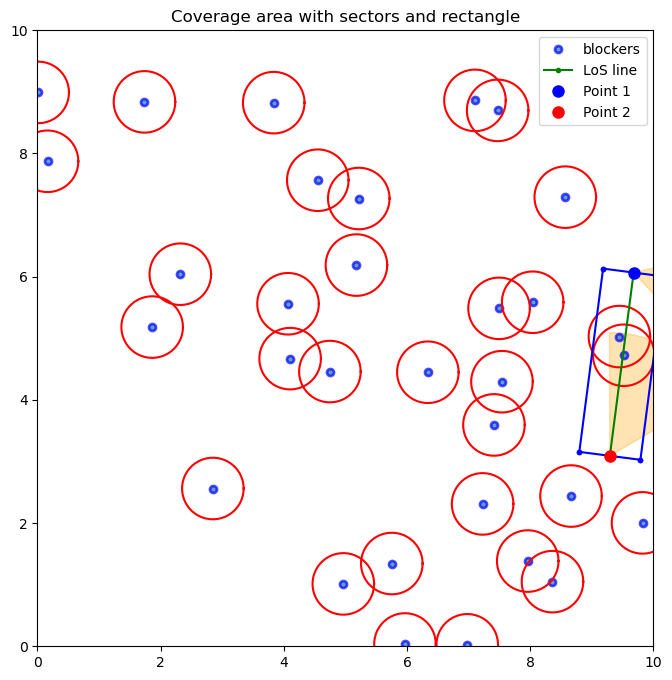

Точки НЕ видимы друг другу
LoS blocked
Вероятность видимости точек с учетом секторов и LoS: 0.013
Вероятность блокировки линии LoS (анализ по имитациям): 0.594
Blocking probability по аналитической модели: 0.593


In [13]:
# Исходные данные
guard_size = 10
poisson_lam_block = 0.3
radius_block = 0.5
distance_Tx_Rx = 3
sector_angle = np.pi / 3  # угол диаграммы направленности 60 градусов
N = 1000  # количество имитаций

# Рисуем круг
def plot_circle(ax, x, y, r):
    angles = np.linspace(0, 2*np.pi, 50)
    x_cir = x + r * np.cos(angles)
    y_cir = y + r * np.sin(angles)
    ax.plot(x_cir, y_cir, 'red')

# Пуассоновский процесс блокаторов
def poisson_point_process(lambda0, area_size):
    Number_block = np.random.poisson(lambda0 * area_size**2)
    x = np.random.uniform(0, area_size, size=Number_block)
    y = np.random.uniform(0, area_size, size=Number_block)
    return x, y

# Прямоугольник вокруг линии
def paint_rectangle(x1, y1, x2, y2, angle):
    difference_angle = 2 * np.pi - angle
    reverse_angle = np.pi / 2 - difference_angle
    opposite_angle = reverse_angle + np.pi
    x_rect_A = x1 + radius_block * np.cos(opposite_angle)
    y_rect_A = y1 + radius_block * np.sin(opposite_angle)
    x_rect_B = x1 + radius_block * np.cos(reverse_angle)
    y_rect_B = y1 + radius_block * np.sin(reverse_angle)
    x_rect_C = x2 + radius_block * np.cos(reverse_angle)
    y_rect_C = y2 + radius_block * np.sin(reverse_angle)
    x_rect_D = x2 + radius_block * np.cos(opposite_angle)
    y_rect_D = y2 + radius_block * np.sin(opposite_angle)
    return x_rect_A, y_rect_A, x_rect_B, y_rect_B, x_rect_C, y_rect_C, x_rect_D, y_rect_D

# Расстояние точки C до линии AB
def distance_point_line(A, B, C):
    return abs((B[0]-A[0])*(A[1]-C[1]) - (A[0]-C[0])*(B[1]-A[1])) / norm(B-A)

def check_distance(A, B, C):
    CA = (C - A) / norm(C - A)
    BA = (B - A) / norm(B - A)
    CB = (C - B) / norm(C - B)
    AB = (A - B) / norm(A - B)
    if np.arccos(np.clip(np.dot(CA, BA), -1, 1)) > 1:
        return norm(C - A)
    if np.arccos(np.clip(np.dot(CB, AB), -1, 1)) > 1:
        return norm(C - B)
    return distance_point_line(A, B, C)

# Проверка пересечения линии с блокаторами
def crossing(list_point, point_1, point_2):
    for circle in list_point:
        if np.round(check_distance(np.array(point_1), np.array(point_2), np.array(circle)), 1) <= radius_block:
            return True
    return False

# Проверка попадания точки в сектор
def point_in_sector(P1, P2, dir_angle, sector_angle):
    vec = np.array(P2) - np.array(P1)
    angle_to_point = np.arctan2(vec[1], vec[0]) % (2*np.pi)
    dir_angle = dir_angle % (2*np.pi)
    diff = abs(angle_to_point - dir_angle)
    diff = min(diff, 2*np.pi - diff)
    return diff <= sector_angle / 2

# Проверка полной видимости с сектором
def is_visible(P1, P2, list_point, sector_angle, dir1=None, dir2=None):
    if dir1 is None:
        dir1 = np.random.uniform(0, 2*np.pi)
    if dir2 is None:
        dir2 = np.random.uniform(0, 2*np.pi)
    in_sector1 = point_in_sector(P1, P2, dir1, sector_angle)
    in_sector2 = point_in_sector(P2, P1, dir2, sector_angle)
    line_clear = not crossing(np.array(list_point), P1, P2)
    return in_sector1 and in_sector2 and line_clear, dir1, dir2

# Визуализация секторов
def plot_sector(ax, P, dir_angle, sector_angle, radius=2, color='orange', alpha=0.3):
    start_angle = np.degrees(dir_angle - sector_angle/2)
    end_angle = np.degrees(dir_angle + sector_angle/2)
    wedge = Wedge(center=P, r=radius, theta1=start_angle, theta2=end_angle, color=color, alpha=alpha)
    ax.add_patch(wedge)

# Генерация случайных блокаторов и линии
x, y = poisson_point_process(poisson_lam_block, guard_size)
x1 = np.random.uniform(0, guard_size)
y1 = np.random.uniform(0, guard_size)
angle = np.random.uniform(0, 2*np.pi)
x2 = x1 + distance_Tx_Rx * np.cos(angle)
y2 = y1 + distance_Tx_Rx * np.sin(angle)

# Прямоугольник вокруг линии
x_rect_A, y_rect_A, x_rect_B, y_rect_B, x_rect_C, y_rect_C, x_rect_D, y_rect_D = paint_rectangle(x1, y1, x2, y2, angle)

list_point_array = np.column_stack((x, y))
point_1 = [x1, y1]
point_2 = [x2, y2]

# Проверка видимости с секторами
visible, dir1, dir2 = is_visible(point_1, point_2, list_point_array, sector_angle)

# Визуализация
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('white')
ax.set_xlim(0, guard_size)
ax.set_ylim(0, guard_size)
ax.set_aspect('equal')
ax.set_title('Coverage area with sectors and rectangle')

# Блокаторы
ax.plot(x, y, '.', alpha=0.7, label="blockers", mec='b', mew=2, ms=10)
for i in range(len(x)):
    plot_circle(ax, x[i], y[i], radius_block)

# Линия LoS
ax.plot([x1, x2], [y1, y2], '.-g', label='LoS line')

# Прямоугольник вокруг линии
ax.plot([x_rect_A, x_rect_B], [y_rect_A, y_rect_B], '.-b')
ax.plot([x_rect_A, x_rect_D], [y_rect_A, y_rect_D], '.-b')
ax.plot([x_rect_B, x_rect_C], [y_rect_B, y_rect_C], '.-b')
ax.plot([x_rect_D, x_rect_C], [y_rect_D, y_rect_C], '.-b')

# Секторы
plot_sector(ax, point_1, dir1, sector_angle)
plot_sector(ax, point_2, dir2, sector_angle)

# Точки
ax.plot(x1, y1, 'bo', markersize=8, label='Point 1')
ax.plot(x2, y2, 'ro', markersize=8, label='Point 2')

ax.legend()
plt.show()

print("Точки видимы друг другу:" if visible else "Точки НЕ видимы друг другу")
# Проверка LoS
if crossing(list_point_array, point_1, point_2):
    print('LoS blocked')
else:
    print('LoS is not blocked')
    
# === Имитационное моделирование вероятности видимости ===
visible_count = 0
los_blocked_count = 0

for i in range(N):
    x, y = poisson_point_process(poisson_lam_block, guard_size)
    x1 = np.random.uniform(0, guard_size)
    y1 = np.random.uniform(0, guard_size)
    angle = np.random.uniform(0, 2*np.pi)
    x2 = x1 + distance_Tx_Rx * np.cos(angle)
    y2 = y1 + distance_Tx_Rx * np.sin(angle)
    
    list_point_array = np.column_stack((x, y))
    point_1 = [x1, y1]
    point_2 = [x2, y2]
    
    # Проверка LoS
    if crossing(list_point_array, point_1, point_2):
        los_blocked_count += 1
    
    # Проверка видимости с секторами
    visible, _, _ = is_visible(point_1, point_2, list_point_array, sector_angle)
    if visible:
        visible_count += 1

# Вероятность видимости с учетом LoS и секторов
prob_visible = visible_count / N
# Вероятность блокировки LoS
prob_los_blocked = los_blocked_count / N

print(f'Вероятность видимости точек с учетом секторов и LoS: {prob_visible:.3f}')
print(f'Вероятность блокировки линии LoS (анализ по имитациям): {prob_los_blocked:.3f}')

# Вероятность блокировки по аналитической формуле
S = 2 * radius_block * distance_Tx_Rx
lamb = poisson_lam_block * S
probability_analytical = 1 - np.exp(-lamb)
print('Blocking probability по аналитической модели: {:.3f}'.format(probability_analytical))


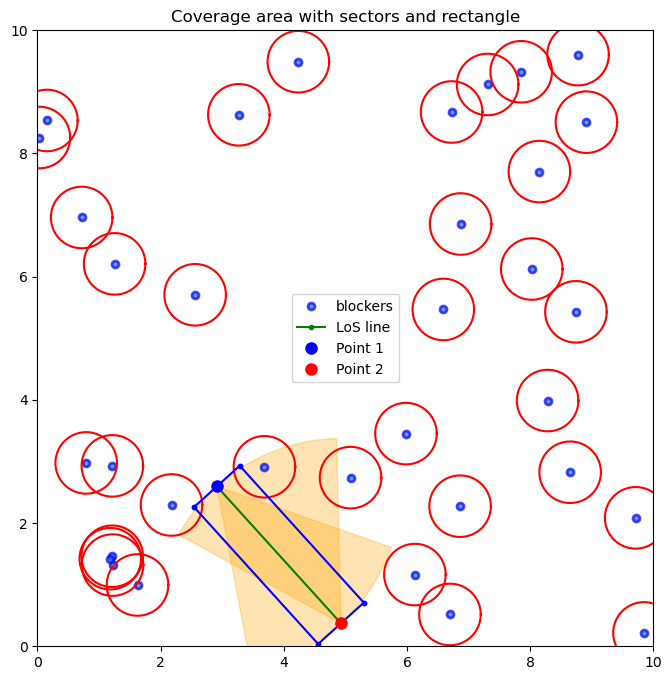

Точки видимы друг другу:
LoS is not blocked
Вероятность видимости точек с учетом секторов и LoS: 0.329
Вероятность блокировки линии LoS (анализ по имитациям): 0.691
Blocking probability по аналитической модели: 0.593


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from matplotlib.patches import Wedge

# Исходные данные
guard_size = 10
poisson_lam_block = 0.3
radius_block = 0.5
distance_Tx_Rx = 3
sector_angle = np.pi / 3  # угол диаграммы направленности 60 градусов
N = 1000  # количество имитаций

# Рисуем круг
def plot_circle(ax, x, y, r):
    angles = np.linspace(0, 2*np.pi, 50)
    x_cir = x + r * np.cos(angles)
    y_cir = y + r * np.sin(angles)
    ax.plot(x_cir, y_cir, 'red')

# Пуассоновский процесс блокаторов
def poisson_point_process(lambda0, area_size):
    Number_block = np.random.poisson(lambda0 * area_size**2)
    x = np.random.uniform(0, area_size, size=Number_block)
    y = np.random.uniform(0, area_size, size=Number_block)
    return x, y

# Прямоугольник вокруг линии
def paint_rectangle(x1, y1, x2, y2, angle):
    difference_angle = 2 * np.pi - angle
    reverse_angle = np.pi / 2 - difference_angle
    opposite_angle = reverse_angle + np.pi
    x_rect_A = x1 + radius_block * np.cos(opposite_angle)
    y_rect_A = y1 + radius_block * np.sin(opposite_angle)
    x_rect_B = x1 + radius_block * np.cos(reverse_angle)
    y_rect_B = y1 + radius_block * np.sin(reverse_angle)
    x_rect_C = x2 + radius_block * np.cos(reverse_angle)
    y_rect_C = y2 + radius_block * np.sin(reverse_angle)
    x_rect_D = x2 + radius_block * np.cos(opposite_angle)
    y_rect_D = y2 + radius_block * np.sin(opposite_angle)
    return x_rect_A, y_rect_A, x_rect_B, y_rect_B, x_rect_C, y_rect_C, x_rect_D, y_rect_D

# Расстояние точки C до линии AB
def distance_point_line(A, B, C):
    return abs((B[0]-A[0])*(A[1]-C[1]) - (A[0]-C[0])*(B[1]-A[1])) / norm(B-A)

def check_distance(A, B, C):
    CA = (C - A) / norm(C - A)
    BA = (B - A) / norm(B - A)
    CB = (C - B) / norm(C - B)
    AB = (A - B) / norm(A - B)
    if np.arccos(np.clip(np.dot(CA, BA), -1, 1)) > 1:
        return norm(C - A)
    if np.arccos(np.clip(np.dot(CB, AB), -1, 1)) > 1:
        return norm(C - B)
    return distance_point_line(A, B, C)

# Проверка пересечения линии с блокаторами
def crossing(list_point, point_1, point_2):
    for circle in list_point:
        if np.round(check_distance(np.array(point_1), np.array(point_2), np.array(circle)), 1) <= radius_block:
            return True
    return False

# Проверка попадания точки в сектор
def point_in_sector(P1, P2, dir_angle, sector_angle):
    vec = np.array(P2) - np.array(P1)
    angle_to_point = np.arctan2(vec[1], vec[0]) % (2*np.pi)
    dir_angle = dir_angle % (2*np.pi)
    diff = abs(angle_to_point - dir_angle)
    diff = min(diff, 2*np.pi - diff)
    return diff <= sector_angle / 2

# Проверка полной видимости с сектором
def is_visible(P1, P2, list_point, sector_angle, dir1=None, dir2=None):
    if dir1 is None:
        dir1 = np.random.uniform(0, 2*np.pi)
    if dir2 is None:
        dir2 = np.random.uniform(0, 2*np.pi)
    in_sector1 = point_in_sector(P1, P2, dir1, sector_angle)
    in_sector2 = point_in_sector(P2, P1, dir2, sector_angle)
    sectors_intersect = in_sector1 and in_sector2
    line_clear = not crossing(np.array(list_point), P1, P2)
    # если сектора пересекаются, точки видимы друг другу
    return sectors_intersect or line_clear, dir1, dir2

# Визуализация секторов
def plot_sector(ax, P, dir_angle, sector_angle, radius=distance_Tx_Rx, color='orange', alpha=0.3):
    start_angle = np.degrees(dir_angle - sector_angle/2)
    end_angle = np.degrees(dir_angle + sector_angle/2)
    wedge = Wedge(center=P, r=radius, theta1=start_angle, theta2=end_angle, color=color, alpha=alpha)
    ax.add_patch(wedge)

# Генерация случайных блокаторов и линии
x, y = poisson_point_process(poisson_lam_block, guard_size)
x1 = np.random.uniform(0, guard_size)
y1 = np.random.uniform(0, guard_size)
angle = np.random.uniform(0, 2*np.pi)
x2 = x1 + distance_Tx_Rx * np.cos(angle)
y2 = y1 + distance_Tx_Rx * np.sin(angle)

# Прямоугольник вокруг линии
x_rect_A, y_rect_A, x_rect_B, y_rect_B, x_rect_C, y_rect_C, x_rect_D, y_rect_D = paint_rectangle(x1, y1, x2, y2, angle)

list_point_array = np.column_stack((x, y))
point_1 = [x1, y1]
point_2 = [x2, y2]

# Проверка видимости с секторами
visible, dir1, dir2 = is_visible(point_1, point_2, list_point_array, sector_angle)

# Визуализация
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('white')
ax.set_xlim(0, guard_size)
ax.set_ylim(0, guard_size)
ax.set_aspect('equal')
ax.set_title('Coverage area with sectors and rectangle')

# Генерация случайной линии внутри квадрата
def generate_points_inside_square(distance, size):
    while True:
        x1 = np.random.uniform(0, size)
        y1 = np.random.uniform(0, size)
        angle = np.random.uniform(0, 2*np.pi)
        x2 = x1 + distance * np.cos(angle)
        y2 = y1 + distance * np.sin(angle)
        if 0 <= x2 <= size and 0 <= y2 <= size:
            return [x1, y1], [x2, y2], angle

# Блокаторы
ax.plot(x, y, '.', alpha=0.7, label="blockers", mec='b', mew=2, ms=10)
for i in range(len(x)):
    plot_circle(ax, x[i], y[i], radius_block)

# Линия LoS
ax.plot([x1, x2], [y1, y2], '.-g', label='LoS line')

# Прямоугольник вокруг линии
ax.plot([x_rect_A, x_rect_B], [y_rect_A, y_rect_B], '.-b')
ax.plot([x_rect_A, x_rect_D], [y_rect_A, y_rect_D], '.-b')
ax.plot([x_rect_B, x_rect_C], [y_rect_B, y_rect_C], '.-b')
ax.plot([x_rect_D, x_rect_C], [y_rect_D, y_rect_C], '.-b')

# Секторы
plot_sector(ax, point_1, dir1, sector_angle)
plot_sector(ax, point_2, dir2, sector_angle)

# Точки
ax.plot(x1, y1, 'bo', markersize=8, label='Point 1')
ax.plot(x2, y2, 'ro', markersize=8, label='Point 2')

ax.legend()
plt.show()

print("Точки видимы друг другу:" if visible else "Точки НЕ видимы друг другу")
# Проверка LoS
if crossing(list_point_array, point_1, point_2):
    print('LoS blocked')
else:
    print('LoS is not blocked')

# === Имитационное моделирование вероятности видимости ===
visible_count = 0
los_blocked_count = 0

for i in range(N):
    x, y = poisson_point_process(poisson_lam_block, guard_size)
    point_1, point_2, angle = generate_points_inside_square(distance_Tx_Rx, guard_size)
    
    list_point_array = np.column_stack((x, y))
    
    # Проверка LoS
    if crossing(list_point_array, point_1, point_2):
        los_blocked_count += 1
    
    # Проверка видимости с секторами
    visible, _, _ = is_visible(point_1, point_2, list_point_array, sector_angle)
    if visible:
        visible_count += 1

# Вероятность видимости с учетом LoS и секторов
prob_visible = visible_count / N
# Вероятность блокировки LoS
prob_los_blocked = los_blocked_count / N

print(f'Вероятность видимости точек с учетом секторов и LoS: {prob_visible:.3f}')
print(f'Вероятность блокировки линии LoS (анализ по имитациям): {prob_los_blocked:.3f}')

# Вероятность блокировки по аналитической формуле
S = 2 * radius_block * distance_Tx_Rx
lamb = poisson_lam_block * S
probability_analytical = 1 - np.exp(-lamb)
print('Blocking probability по аналитической модели: {:.3f}'.format(probability_analytical))
